In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


# Goal of the project

In this little tutorial you are going to discover some statistical / machine learning methods that allow to evaluate the importance of features regarding a regression task.

Then the main objective is that you could use them in order to create your own GRN inference algorithms:

+ Choose one of the methods.
+ Describe its principles, its main underlying hypothesis and limitations
+ Create a new GRN inference algorithm, by modifying the `GRN_inference_GENIE3` notebook.
+ Run your algorithm and compare it to the GENIE3 results.
+ Get the results of the other groups and compare them (use the ` seaborn` `clustermap` function), what do you notice? 
+ Propose a simple way to combine the results of the different algorithms (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3512113/)

# Dimensionality reduction

This unsupervised learning method aims at representing high dimensional data, (i.e. described by a large number of features) in a space with few descriptors, while keeping as much information as possible about the original data.

### Curse of dimensionality

The analysis of data described in large dimensional spaces is a particularly complicated task: this issue is known as the "curse of dimensionality". Why is it problematic to deal with this kind of data?:

+ This type of data requires a large amount of storage space and results in particularly long computation times. 
+ Distance measurements, on which a large number of techniques are based (such as K-NN or K-Means algorithms), lose their discrimination in this type of space. As a result, most machine learning algorithms lose their effectiveness when used in high-dimensional spaces. 

One solution to this problem is to apply dimensionality reduction algorithms, in order to represent the original data in a smaller dimensionality space, while preserving the initial information and characteristics as well as possible. Once projected into this new space, the storage of data and the computing power required for their analysis are less constraining, the performance of algorithms is often better and, if the new space is described through 2 or 3 descriptors, the visualization of the data becomes very easy.

### Feature selection and feature extraction

There are two main families of such approaches, called "feature selection" and "feature extraction". 

The first aims to select a relevant subset of descriptors from those available, eliminating noisy or redundant descriptors. 

The second family aims to create new descriptors by combining the original ones. Some approaches are based on linear (such as Principal component analysis) or non-linear (such as t-SNE) transformations.

### Feature selection and GRN inference

Choosing the most important genes, given the regression task that consist in predicting the $i$-th gene expression by considering the expression of other genes $\in TF\setminus \{i\}$, corresponds in fact to a __feature selection task__:

+ Given the space of the expression of genes $\in TF\setminus \{i\}$ (i.e. each gene denotes one dimension which leads to a $|TF\setminus \{i\}|$ dimensional space)
+ We aim at __selecting__ a subset $TF^* \subset TF\setminus \{i\} $ (subset of genes) that enables to predict the activity of gene $i$, without incurring in a too large predictive error.
+ __Underlying hypothesis__: if the __gene expression of a subset of TFs__ enables to __model and predict correctly__ the __target gene expression__, then probably the __target gene expression__ is in fact __caused__ or __directly influenced__ by the __selected TFs expression__.__

# Load the example dataset (iris)
+ Load the iris dataset
+ The first 3 columns are used as input features
+ The last column is used as target variable

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :3]  # the input will be the first 3 columns
y = iris.data[:,3] # the target variable will be the last column

# METHOD1:  [F-Regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)

This method builds a __linear model__ for each feature to test its effect on the target variable prediction, and then it outputs a score for each feature.

+ Let $y$ be vector containing the target variable values.

$$\mathbf{y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}}$$

+ Let $X$ be a $n\times p$ matrix. Each one of the $n$ rows records the coordinates of a data point in a p-dimensional feature space, and each column denoted $X_{j}$ corresponds to a different feature. 

$X=\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix} = (X_1,X_2,...,X_p)$


+ Let $p$ be the number of features and $n$ the number of data points.

Building a linear model between feature $X_j$ and the target variable $y$ consist in finding parameters $a$ and $b$ s.t.:

$$\boxed{y = a \cdot X_{j} + b + \epsilon }$$

Where $a$ is the slope of the linear relation and $b$ is the intercept and $\epsilon$ is the residual (the goal is to minimize the norm 2 of the residual).

In practice the sklearn implementation computes:

1) the correlation between each feature $j$ and the target:

+ Let $\bar{X_j} = \sum_i\frac{X_{i,j}}{n}$ (mean along feature $j$)
+ Let $\bar{y} = \sum_i\frac{y_{i}}{n}$ (mean value of the target variable)
+ Let $std(X_j) = \sqrt{\sum_i\frac{(X_{i,j} - \bar{X_j})^2}{n}}$ (std along feature $j$)
+ Let $std(y) = \sqrt{\sum_i\frac{(y_i - \bar{y})^2}{n}}$ (std along feature $j$)

$$corr(X_{j}, y) = \frac{\sum_i \frac{(X_{i,j} - \bar{X_j})\times (y_i - \bar{y})}{n}}{std(X_j)\times std(y)}$$

2) Computes an F score using the correlation:

$$F = \frac{corr(X_{j}, y)^2}{(1 - corr(X_{j}, y)^2)} \times  d$$

where $d$ denotes the degree of freedom

3) Computes the corresponding p-value (probability to observe the data under no-correlation null-hypothesis). 

#### Remark
Notice that could also use directly the __absolute value of the correlation__ to score the features

## Example
Use a f-regression method to compute the importance of each input column regarding the regression of the last one
+   Create a f-regression instance

In [4]:
from sklearn.feature_selection import f_regression
Fscores, p_values = f_regression(X, y, center=True)

+ Plot the Fscores and p-values for each feature

Text(0, 0.5, 'F-scores')

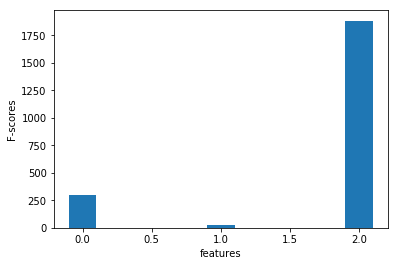

In [5]:
plt.bar(range(len(Fscores)), Fscores,0.2)
plt.xlabel("features")
plt.ylabel("F-scores")

Text(0, 0.5, 'p-values')

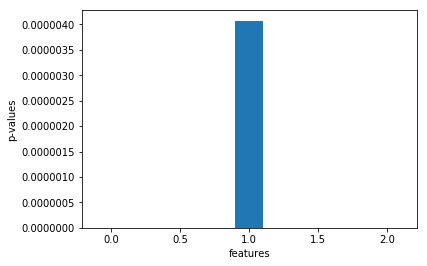

In [6]:
plt.bar(range(len(p_values)), p_values,0.2)
plt.xlabel("features")
plt.ylabel("p-values")

# METHOD2: [Mutual Information Regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression)

This methods aims at estimating the mutual information between a continuous feature and a continuous target variable.

The mutual information between two random variables, measures the dependency between the variables. 
+ It is equal to zero if the two random variables are independent
+ Higher values $\to$ higher dependency.
+ It is a non-negative measure

In the __discrete case__, the Mutual Information formula between two random variables $X$ and $Y$ is:


$$MI(X,Y) = \sum_{y\in Y} \sum_{x\in X} p(x,y) \log{\left( \frac{p(x,y)}{p(x)p(y)}\right)}$$
 
With:
+ $p(x,y)$ : joint probability distribution of $X$ and $Y$
+ $p(x)$ and $p(y)$ : marginal probability distributions of $X$ and $Y$.

In the __continuous case__, the Mutual Information is defined analogously:


$$MI(X,Y) = \int_{y\in Y} \int_{x\in X} p(x,y) \log{\left( \frac{p(x,y)}{p(x)p(y)}\right)} dxdy$$

With:

+ $p(x,y)$ : joint probability density of $X$ and $Y$
+ $p(x)$ and $p(y)$ : marginal probability density of $X$ and $Y$.

The `sklearn` implemenatation is based on nonparametric methods that estimate entropy using a k-nearest neighbors approach (the only parameter is the number of neighbors).

## Example
Use a Mutual Information Regression method to compute the dependency of the target variable with respect to the different features
+   Create a mutual information regression instance

In [7]:
from sklearn.feature_selection import mutual_info_regression
mutual_information = mutual_info_regression(X,
                                            y,
                                            n_neighbors=3)

+ Plot the mutual information between the target variable and each one of the features

Text(0, 0.5, 'Mutual Information')

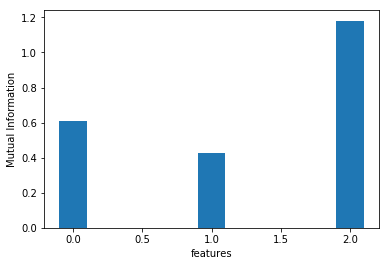

In [8]:
plt.bar(range(len(mutual_information)), mutual_information,0.2)
plt.xlabel("features")
plt.ylabel("Mutual Information")

# METHOD3: L1-based feature selection

## Linear regression (recall)

+ Let $y$ be a vector containing the target variable values $y_i$, also called dependent variable.


$$\mathbf{y} ={\begin{pmatrix}y_{1}\\y_{2}\\\vdots \\y_{n}\end{pmatrix}}$$

+ Let $X$ be a $n\times p$ matrix. Each one of the $n$ rows records the coordinates of a data point in a p-dimensional feature space, and each column denoted $X_{j}$ corresponds to a different feature. In the context of linear regression, features are also known as explanatory variables, input variables or independent variables.

$$X=\begin{pmatrix}1&x_{11}&\cdots &x_{1p}\\1&x_{21}&\cdots &x_{2p}\\\vdots &\vdots &\ddots &\vdots \\1&x_{n1}&\cdots &x_{np}\end{pmatrix} = (X_1,X_2,...,X_p)$$

Linear regression models assume that there is a linear relationship between the target variable $y$ and each explanatory variable $X_j$:

$$\boxed{\mathbf{y} =X \cdot \beta + \varepsilon}$$

+ $\beta$ is a ($p+1$)-dimensional parameter vector:
    + $\beta _{0}$ is the intercept term.
    + The remaining $p$ elements are the regression coefficients of each one of the $p$ input variables.
    

$$\beta =\begin{pmatrix}\beta _{0}\\\beta _{1}\\\beta _{2}\\\vdots \\\beta _{p}\end{pmatrix}$$

+ $\varepsilon$ is a vector of errors (residual) or "noise". This vector contains the difference between the target variable and the best linear model that was obtained using the input variables. Usually the coefficient $\beta$ is determined s.t. $||\varepsilon||^2_2$ is minimized (Least squares).


$$\varepsilon=\begin{pmatrix}\varepsilon _{1}\\\varepsilon _{2}\\\vdots \\\varepsilon _{n}\end{pmatrix}$$

__The objective function (least squares) is simply__:

$$Argmin_{\beta} \; ||\varepsilon||^2_2 = \boxed{Argmin_{\beta} \;||\mathbf{y} - X \cdot \beta||_2^2}$$

## L1 penalization

Sometimes it is useful to apply a __regularization__ to the linear model, in order to get parameter values that have some particular characteristics.

The __Lasso method__ (least absolute shrinkage and selection operator) constrains the parameter vector to be s.t. its L1-norm $||\beta ||_1$, is smaller than a given value.

There exist also an unconstrained version that is equivalent to the previous one. In this formulation, a penalty term $\alpha \cdot ||\beta ||_1$ is added to the least squares objective function:


$$\boxed{Argmin_{\beta} \;||\mathbf{y} - X \cdot \beta||_2^2 + \alpha \cdot ||\beta ||_1}$$

The linear regression with L1 penalization, can be solved by minimizing the previous equation using convex optimization methods for instance or specific algorithms such as the  least angle regression algorithm (LAR).

In practice linear models with an L1 penalty have __sparse solutions__ (many coefficients are equal to 0). Therefore the Lasso method directly selects more important features.

## Example
Use a LASSO Regression method to compute the dependency of the target variable with respect to the different features
+   Create two different LASSO regression for comparison:
    + Lasso: tackle the L1 penalized linear regression with the coordinate descent algorithm
    + RandomizedLasso: This method run LASSO on train data subsamples (with randomized scaled features). Then the features selected more often are assumed to be promising features (high score), since they are more stable, and more consistently used to build the linear models. This methods belongs to the so called __stability selection__ family.

In [9]:
from sklearn.linear_model import Lasso,LassoLars,RandomizedLasso

In [10]:
lasso = Lasso(alpha=0.01,          # L1 penalty (higher -> more zeros)
              fit_intercept=True,# Include an intercept in the linear regression?
              normalize=True,     # Standardize each column (z-score) before running the regression
              max_iter=1000,      # Maximal number of optimization iterations
              tol=0.0001,         # Tolerance for optimization (updates are smaller than tol)
              positive=False,     # Force coefficients to be positive
              selection='random', # update one feature at a time randomly or "cycle" to loop sequentially over features 
             )

In [11]:
randomizedlasso = RandomizedLasso(alpha='aic', # use the aic index to choose the maximal complexity of the model or a real number for the penalty
                                  scaling=0.5, # randomly scale the features by this factor
                                  sample_fraction=0.5, # fraction of data points to be used in each sample
                                  n_resampling=500,  # nb of randomized linear models
                                  selection_threshold=None, # select features having a score higher that this threshold
                                  fit_intercept=True, # include an intercept in the models
                                  normalize=True,
                                  max_iter=500,
                                  verbose = True)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


+ Train the models

In [12]:
lasso = lasso.fit(X,y)
randomizedlasso.fit(X,y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Memory is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Parallel is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can 

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=Deprec

RandomizedLasso(alpha='aic', eps=2.220446049250313e-16, fit_intercept=True,
        max_iter=500, memory=None, n_jobs=None, n_resampling=500,
        normalize=True, pre_dispatch='3*n_jobs', precompute='auto',
        random_state=None, sample_fraction=0.5, scaling=0.5,
        selection_threshold=None, verbose=True)

+ Plot the LASSO scores

Text(0, 0.5, 'LASSO coefficients')

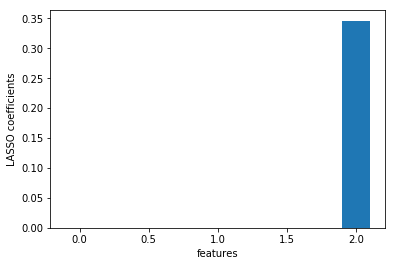

In [13]:
lasso_coefs = lasso.coef_
plt.bar(range(len(lasso_coefs)), lasso_coefs,0.2)
plt.xlabel("features")
plt.ylabel("LASSO coefficients")

Text(0, 0.5, 'LASSO Stability Selection coefficients')

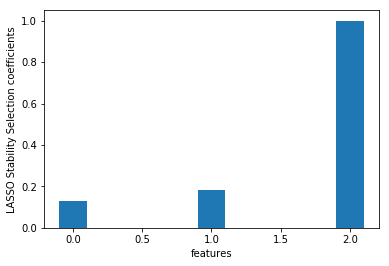

In [14]:
randomizedlasso_coefs = randomizedlasso.scores_
plt.bar(range(len(randomizedlasso_coefs)), randomizedlasso_coefs,0.2)
plt.xlabel("features")
plt.ylabel("LASSO Stability Selection coefficients")

# Bonus 
If you have already finished the project, and if you want to test other methods and other approaches, you can try to apply:
+ The Bayesian ridge regression: [link1](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html), [link2](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
+ The [Support Vector Regression](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)
+ The [ExtraTrees Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)
+ The [Gradient Boosting Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)